In [36]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

from tqdm import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt

from utils import ActorCritic

In [37]:
# Hyperparameters
max_timesteps = 3000
n_epochs = 10
learning_rate = 0.0003
gamma = 0.99
eps_clip = 0.2
K_epochs = 4
action_std = 0.5
batch_size = 64
update_timestep = 2000

In [38]:
def compute_gae(done, rewards, values, next_values, gamma=0.99, lambda_=0.95):
    assert len(values) == len(next_values) == len(rewards) == len(done)

    advantages = torch.zeros(done.shape[0], dtype=torch.float32)
    returns = torch.zeros(done.shape[0], dtype=torch.float32)
    last_advantage = 0
    last_return = 0

    for t in reversed(range(done.shape[0])):
        mask = 1.0 - done[t]
        last_value = next_values[t] * mask
        last_advantage = last_advantage * mask
        last_return = last_return * mask

        delta = rewards[t] + gamma * last_value - values[t]
        last_advantage = delta + gamma * lambda_ * last_advantage
        last_return = rewards[t] + gamma * last_return

        advantages[t] = last_advantage
        returns[t] = last_return

    return advantages, returns

In [39]:
def collect_trajectories(env, model, alpha, n_steps):

    states, actions, rewards, log_ps, state_values, dones = [], [], [], [], [], []

    state, _ = env.reset()
    

    total_reward = 0
    step_count = 0

    for _ in range(n_steps):
        state = torch.FloatTensor(state)
        action, log_p, state_value, entropy = model(state, alpha)
        next_state, reward, terminated, truncated, _ = env.step(action.item())
        done = terminated or truncated

        states.append(state)
        actions.append(action)
        rewards.append(reward)
        log_ps.append(log_p)
        state_values.append(state_value)
        dones.append(done)

        state = next_state
        total_reward += reward
        step_count += 1

        if done:
            state, _ = env.reset()
            
    next_value = model.critic(torch.FloatTensor(next_state).unsqueeze(0)).squeeze(0)
    
    states = torch.stack(states)
    actions = torch.LongTensor(actions)
    rewards = torch.LongTensor(rewards)
    state_values = torch.FloatTensor(state_values)
    dones = torch.LongTensor(dones)
    next_state_values = torch.concatenate((state_values[1:], next_value))
    
    
    advantages, returns = compute_gae(dones, rewards, state_values, next_state_values)
         
    # Normalize advantages
    advantages = torch.FloatTensor(advantages)
    returns = advantages + torch.FloatTensor(state_values)
            
    trajectories = {
        "states" : states.detach(),
        "actions" : actions.detach(),
        "rewards" : rewards.detach(),
        "dones" : dones.detach(),
        "log_ps" : torch.stack(log_ps).detach(),
        "state_values": state_values.detach(),
        "next_state_values": next_state_values.detach(),
        "returns" : returns.detach(),
        "advantages" : advantages.detach(),
    }
    
    return trajectories


# trajectories = collect_trajectories(env, model, n_steps=128)

# for key in trajectories:
#     print(key, trajectories[key].shape)

def shufffle_trajectory(trajectories):
    length = trajectories['states'].shape[0]
    permutation = torch.randperm(length)

    shuffled_trajectories = {key: tensor[permutation] for key, tensor in trajectories.items()}
    return shuffled_trajectories

# shuffled_trajectories = shufffle_trajectory(trajectories)

In [40]:
def ppo_optimization(trajectories, model, alpha, optimizer, epochs, batch_size):
    
    model.train()
    
    traj_states = trajectories["states"]
    traj_actions = trajectories["actions"]
    traj_log_ps = trajectories["log_ps"]
    traj_returns = trajectories["returns"]  
    traj_advantages = trajectories["advantages"]


    len_trajectory = traj_states.shape[0]

    for epoch in range(1, epochs+1):
        for i in range(len_trajectory // batch_size):
            state = traj_states[batch_size*i:batch_size*(i+1)]
            action = traj_actions[batch_size*i:batch_size*(i+1)]
            log_p = traj_log_ps[batch_size*i:batch_size*(i+1)]
            return_ = traj_returns[batch_size*i:batch_size*(i+1)]
            advantage = traj_advantages[batch_size*i:batch_size*(i+1)]
            
            new_action, new_log_p, new_state_value, entropy = model(state, alpha, action)
            assert(new_action == action).all()
            
            
            advantage = (advantage - advantage.mean()) / (advantage.std() + 1e-8)
                    
            new_log_p, log_p, advantage = new_log_p.reshape(-1), log_p.reshape(-1), advantage.reshape(-1)
            
            ratio = torch.exp(new_log_p - log_p.detach())
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1-0.2, 1+0.2) * advantage
            policy_loss = - torch.min(surr1, surr2).mean()
            
            
            return_, new_state_value = return_.reshape(-1), new_state_value.reshape(-1)

            value_loss = ((return_ - new_state_value)**2).mean()

            loss = policy_loss - 2e-7*entropy.mean() + 0.5*value_loss

            optimizer.zero_grad()
            loss.backward()
            clip_factor = torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            optimizer.step()
            
# ppo_optimization(trajectories, model, optimizer, epochs=1, batch_size=5)

In [77]:
def evaluate(env, model, alpha):
    model.eval()

    state, _ = env.reset()
        
    total_reward = 0
    step_count = 0

    trajectory = []

    while True:
        trajectory.append(state)
        state = torch.FloatTensor(state)
        with torch.no_grad():
            action, log_p, state_value, entropy = model(state, alpha)
        next_state, reward, terminated, truncated, _ = env.step(action.item())
        done = terminated or truncated

        state = next_state
        total_reward += reward
        step_count += 1

        
        
        if done:
            break
        
    return step_count, trajectory

In [53]:
def random_alpha(n_anchors):
    random_probs = torch.rand(1, n_anchors)
    proba_vector = random_probs / random_probs.sum(dim=1, keepdim=True)
    return proba_vector[0]

In [142]:
env = gym.make("CartPole-v1")

n_anchors = 2
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n


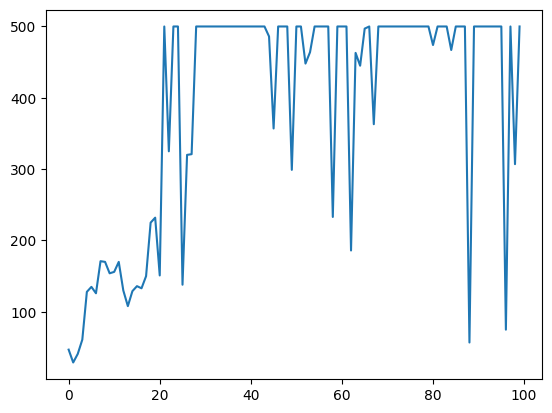

Reward: 500.0: 100%|██████████| 100/100 [00:37<00:00,  2.65it/s]


In [150]:
model = ActorCriticCategorical(
    n_anchors,
    state_dim,
    action_dim,
    same_init=True,
    actor_hidden_layers=[64],
    critic_hidden_layers=[64]
)
optimizer = optim.AdamW(model.parameters(), lr=0.01)

rewards = []

tqdm_epochs = tqdm(range(1, 100+1))
for epochs in tqdm_epochs:
    
    alpha = random_alpha(n_anchors)
    # alpha = torch.tensor([0.5, 0.5])
    # print(alpha)
    
    trajectory = collect_trajectories(env, model, alpha, n_steps=1024)
    shuffled_trajectory = shufffle_trajectory(trajectory)
    ppo_optimization(shuffled_trajectory, model, alpha, optimizer, epochs=5, batch_size=256)
    

    # final_reward = np.mean([evaluate(env, model, torch.tensor([1., 0.])) for _ in range(1)])
    final_reward = np.mean([evaluate(env, model, random_alpha(n_anchors))[0] for _ in range(1)])
    rewards.append(final_reward)
    
    tqdm_epochs.set_description(f'Reward: {final_reward}')
    
    
    if epochs % 1 == 0:
        clear_output(True)
        plt.plot(rewards)
        plt.show()

In [151]:
def get_descriptor(states):

    distance_traveled = 0
    angles_traveled = 0

    for i in range(1, len(states)):
        distance_traveled += abs(states[i][0] - states[i-1][0])
        angles_traveled += abs(states[i][2] - states[i-1][2])

    median_speed = np.median([states[i][1] for i in range(len(states))])
    median_angular_speed = np.median([states[i][3] for i in range(len(states))])

    return float(distance_traveled), float(angles_traveled), float(median_speed), float(median_angular_speed)

In [172]:
descriptors = []
rewards = []
for _ in tqdm(range(1000)):
    reward, states = evaluate(env, model, random_alpha(n_anchors))
    descriptors.append(get_descriptor(states))
    rewards.append(reward)
    
descriptors_array = np.array(descriptors)

100%|██████████| 1000/1000 [01:08<00:00, 14.63it/s]


In [184]:
anchor_descriptors = []
for i in range(n_anchors):
    # if i == 1:
        alpha = torch.tensor([0.]*n_anchors)
        alpha[i] = 1.
        for _ in tqdm(range(100)):
            _, states = evaluate(env, model, alpha)
            anchor_descriptors.append(get_descriptor(states))
    # break


100%|██████████| 100/100 [00:08<00:00, 12.32it/s]


/tmp/ipykernel_5629/3485009464.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs.set_xticklabels(x1_bins.round(1))
/tmp/ipykernel_5629/3485009464.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs.set_yticklabels(x2_bins.round(1))


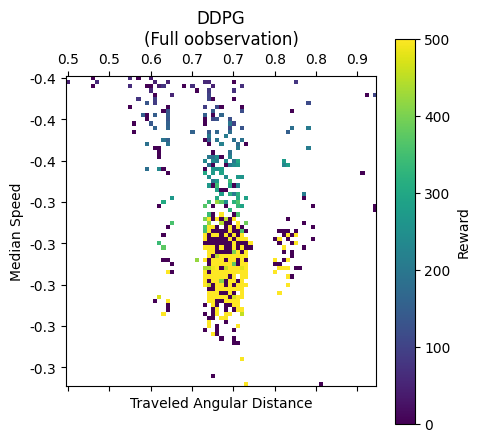

In [185]:
import matplotlib.pyplot as plt

x1, x2 = 1, 2

x1_min = descriptors_array[:, x1].min()
x1_max = descriptors_array[:, x1].max()
x2_min = descriptors_array[:, x2].min()
x2_max = descriptors_array[:, x2].max()

N = 75

x1_bins = np.linspace(x1_min, x1_max, N)
x2_bins = np.linspace(x2_min, x2_max, N)

map_grid = np.full((N, N), np.nan)

def get_bin(value, bins):
    return np.digitize(value, bins) - 1


for descriptor, reward in zip(descriptors, rewards):
    feature1, feature2 = descriptor[x1], descriptor[x2]
    f1_bin = get_bin(feature1, x1_bins)
    f2_bin = get_bin(feature2, x2_bins)
    map_grid[f1_bin][f2_bin] = reward
    
for descriptor in anchor_descriptors:
    feature1, feature2 = descriptor[x1], descriptor[x2]
    f1_bin = get_bin(feature1, x1_bins)
    f2_bin = get_bin(feature2, x2_bins)
    map_grid[f1_bin][f2_bin] = -1


fig, axs = plt.subplots(1, 1, figsize=(5,5))


cax = axs.matshow(map_grid, cmap="viridis", vmin=0, vmax=500)
axs.set_title('DDPG\n(Full oobservation)', loc='center')

axs.set_ylabel('Median Speed')
axs.set_xlabel('Traveled Angular Distance')
axs.set_xticklabels(x1_bins.round(1))
axs.set_yticklabels(x2_bins.round(1))

fig.colorbar(cax, ax=axs, orientation='vertical', label='Reward')
plt.show()

In [15]:
list(model.actor[0].anchors[1].parameters())[0]

Parameter containing:
tensor([[-0.0121, -0.4261, -1.4711, -0.6037],
        [ 0.2981,  0.5371,  2.4436,  0.6428],
        [ 0.1864, -0.1016,  0.5864,  0.2272],
        [ 0.0387, -0.1761,  0.2448, -0.1753],
        [ 0.2565,  0.0590, -0.1187, -0.1157],
        [ 0.0846, -0.1440,  0.6531,  0.5530],
        [ 0.2185,  0.3672,  1.8319,  0.6872],
        [-0.2589,  0.2016, -0.1390, -0.2313],
        [-0.0100,  0.1635,  0.0509, -0.0963],
        [ 0.2862,  0.1034,  0.2664,  0.2341],
        [-0.0727, -0.0877,  0.1333, -0.1220],
        [-0.1427, -0.1098, -0.4204, -0.5226],
        [ 0.3680,  0.3992, -1.9358, -0.2089],
        [ 0.0906, -0.0948, -0.4058,  0.0652],
        [-0.0060,  0.0653,  1.5346,  1.0061],
        [-0.0407, -0.1982,  0.3043,  0.1469],
        [ 0.3366, -0.2492, -0.1052, -0.4823],
        [-0.1128, -0.1373, -0.3459, -0.5769],
        [-0.0102, -0.2757, -1.5832, -0.4992],
        [ 0.2134, -0.2820, -0.1459, -0.1150],
        [ 0.3685, -0.4426,  0.3329,  0.2199],
        [ 0.

In [16]:
model

ActorCritic(
  (actor): Sequential(
    (0): Linear(
      (anchors): ModuleList(
        (0-1): 2 x Linear(in_features=4, out_features=64, bias=True)
      )
    )
    (1): ReLU()
    (2): Linear(
      (anchors): ModuleList(
        (0-1): 2 x Linear(in_features=64, out_features=2, bias=True)
      )
    )
  )
  (critic): Sequential(
    (0): Linear(in_features=4, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
)